# About

We need a good order parameter to distinguish stability.
This notebook is for developing this OP, which is essentially a measure of how far apart the protomer falls.

In [1]:
import signac
import numpy as np
from glotzformats import reader
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import tqdm
import gsd
from gsd import fl
from gsd import hoomd as gsdhoomd
from freud.box import Box
import itertools

%matplotlib notebook

### My analysis
The centroid_msd function computes the distance of the particles from their centroid at each step.
This is my preferred form of analysis.
**Note: I am logging the value directly in HOOMD now, but I may still need to recalculate it on the fly.**

In [2]:
def centroid_MSD(positions, box):
    """Compute the MSD of particles relative to the centroid.
    This method accounts for box periodicity and the minimum image convention
    
    Args:
        positions(np.array): A position array of shape (frames, particles, coordinates)
        box (glotzformats.box): The box"""
    positions = positions.copy()
    box = traj[0].box # Use the first box since they're all identical

    positions[:, :, 0] = np.mod(positions[:, :, 0]+box.Lx/2, box.Lx)
    positions[:, :, 1] = np.mod(positions[:, :, 1]+box.Ly/2, box.Ly)
    positions[:, :, 2] = np.mod(positions[:, :, 2]+box.Lz/2, box.Lz)
    positions[:, :, 0] = np.mod(positions[:, :, 0]+box.Lx/2, box.Lx)
    positions[:, :, 1] = np.mod(positions[:, :, 1]+box.Ly/2, box.Ly)
    positions[:, :, 2] = np.mod(positions[:, :, 2]+box.Lz/2, box.Lz)

    # To apply minimum image convention, just choose one of the particles
    # as the basis and find the closest images of everything to that one
    basis_particle = positions[:, np.newaxis, 0, :]
    vectors = positions-basis_particle
    positions[:, :, 0] = np.where(np.abs(vectors[:, :, 0]) > box.Lx/2,
                                box.Lx - np.abs(positions[:, :, 0]),
                                positions[:, :, 0])
    positions[:, :, 1] = np.where(np.abs(vectors[:, :, 1]) > box.Ly/2,
                                box.Ly - np.abs(positions[:, :, 1]),
                                positions[:, :, 1])
    positions[:, :, 2] = np.where(np.abs(vectors[:, :, 2]) > box.Lz/2,
                                box.Lz - np.abs(positions[:, :, 2]),
                                positions[:, :, 2])

    # Now compute the centroids for each step and find deviations
    centroids = np.mean(positions, axis = 1)
    centroids = centroids[:, np.newaxis, :]
    deltas = positions - centroids
    distances = np.linalg.norm(deltas, axis = -1)
    avg_distances = np.mean(distances, axis = -1)
    return avg_distances

In [3]:
def centroid_Rg(positions, box):
    """Compute the radius of gyration of particles relative to the centroid.
    This method accounts for box periodicity and the minimum image convention
    
    Args:
        positions(np.array): A position array of shape (frames, particles, coordinates)
        box (glotzformats.box): The box"""
    positions = positions.copy()
    box = traj[0].box # Use the first box since they're all identical

    positions[:, :, 0] = np.mod(positions[:, :, 0]+box.Lx/2, box.Lx)
    positions[:, :, 1] = np.mod(positions[:, :, 1]+box.Ly/2, box.Ly)
    positions[:, :, 2] = np.mod(positions[:, :, 2]+box.Lz/2, box.Lz)
    positions[:, :, 0] = np.mod(positions[:, :, 0]+box.Lx/2, box.Lx)
    positions[:, :, 1] = np.mod(positions[:, :, 1]+box.Ly/2, box.Ly)
    positions[:, :, 2] = np.mod(positions[:, :, 2]+box.Lz/2, box.Lz)

    # To apply minimum image convention, just choose one of the particles
    # as the basis and find the closest images of everything to that one
    basis_particle = positions[:, np.newaxis, 0, :]
    vectors = positions-basis_particle
    positions[:, :, 0] = np.where(np.abs(vectors[:, :, 0]) > box.Lx/2,
                                box.Lx - np.abs(positions[:, :, 0]),
                                positions[:, :, 0])
    positions[:, :, 1] = np.where(np.abs(vectors[:, :, 1]) > box.Ly/2,
                                box.Ly - np.abs(positions[:, :, 1]),
                                positions[:, :, 1])
    positions[:, :, 2] = np.where(np.abs(vectors[:, :, 2]) > box.Lz/2,
                                box.Lz - np.abs(positions[:, :, 2]),
                                positions[:, :, 2])

    # Now compute the centroids for each step and find deviations
    centroids = np.mean(positions, axis = 1)
    centroids = centroids[:, np.newaxis, :]
    deltas = positions - centroids
    distances = np.linalg.norm(deltas, axis = -1)
    
    # Only difference with simple distance calc is that instead of averaging here, we take the norm
    rgs = np.linalg.norm(distances, axis = -1)/np.sqrt(distances.shape[1])
    return rgs

In [4]:
r = reader.PosFileReader()

with open('figure_files/denatured_protomer.pos') as f:
    traj = r.read(f)
    traj.load_arrays()
    print("The Rg for the denatured protomer is {}".format(centroid_Rg(traj.positions, traj[-1].box)[-1]))
    
with open('figure_files/intact_protomer.pos') as f:
    traj = r.read(f)
    traj.load_arrays()
    print("The Rg for the intact protomer is {}".format(centroid_Rg(traj.positions, traj[-1].box)[-1]))
    

The Rg for the denatured protomer is 26.227733612060547
The Rg for the intact protomer is 6.328243255615234


### Unit conversion

While my data space is in terms of kappa, ideally we would want the data space to be in terms of the concentrations.
This function performs the conversion for plotting purposes.

In [5]:
def kappa_to_conc(kappa, eps=None, T=None):
    """Converts kappa (the inverse screening length) into a concentration in millimolar units"""
    e = 1.60217646e-19
    a = 8.864187817e-12
    k = 1.3806485279e-23
    Na = 6.0221415e23
    T_def = 300
    epsr_def = 78 #Note that this term is temperature dependent
    if eps is None:
        eps = epsr_def
    if T is None:
        T = T_def
    return 1000*(a*eps*k*T)/(((kappa * 10**(9))**(-2)) * (e**2) * Na * 2000)
kappa_to_conc(0.73)

49.360780329933135

### Standardized plot

In [6]:
#mpl.rcParams.update(mpl.rcParamsDefault) # To reset to defaults
plt.rcParams['errorbar.capsize'] = 5.0
plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Times')
class pretty_error_plot(object):
    def __init__(self, fig=None, ax=None, fs=None, xlabel=None, ylabel=None, title=None,
                 cmap=None, error_fill=False, use_legend=True, ypad=0.05, xpad=0.05, facets=(),
                 rescale_plot=True):
        if fig is None and ax is None:
            if facets:
                if fs is None:
                    fs = (8, 6)
                fig, ax = plt.subplots(*facets, figsize=fs)
                plt.subplots_adjust(hspace=0.3, wspace=0.3)
            else:
                fig, ax = plt.subplots(1, 1)
        self.fig = fig
        self.ax = ax

        # Standardize some plotting standards
        if rescale_plot:
            # Whether or not to enforce 4/3 plot
            dims = fig.get_size_inches()
            if np.abs(dims[0]/dims[1] - 4/3) > 0.1:
                fig.set_size_inches(dims[1]*4/3, dims[1])
        if facets:
            for a in ax.flatten():
                a.spines["top"].set_visible(False)  
                a.spines["right"].set_visible(False)  
        else:
            ax.spines["top"].set_visible(False)  
            ax.spines["right"].set_visible(False)  

        # Labeling
        if facets:
            for a in ax.flatten():
                a.tick_params(axis='both', which='major', labelsize=16)
                a.tick_params(axis='both', which='minor', labelsize=16)
        else:
            ax.tick_params(axis='both', which='major', labelsize=16)
            ax.tick_params(axis='both', which='minor', labelsize=16)

        if title:
            self.title = title
            if facets:
                fig.suptitle(title, fontsize=24)
            else:
                ax.set_title(title, fontsize=24)  
        if xlabel:
            self.xlabel = xlabel
            if facets:
                # Only label the edges
                for i, ax_row in enumerate(ax):
                    for j, a in enumerate(ax_row):
                        if i == facets[0]-1:
                            a.set_xlabel(xlabel, fontsize=20)  
            else:
                ax.set_xlabel(xlabel, fontsize=20)  
        if ylabel:
            self.ylabel = ylabel
            if facets:
                for i, ax_row in enumerate(ax):
                    for j, a in enumerate(ax_row):
                        if j == 0:
                            a.set_ylabel(ylabel, fontsize=20)  
            else:
                ax.set_ylabel(ylabel, fontsize=20)  
        
        self.num_plots = 0
        if cmap:
            self.cmap = plt.get_cmap(cmap)
        else:
            self.cmap = None
        self.use_legend = use_legend
        self.xpad = xpad
        self.ypad = ypad
        self.error_fill = error_fill
        self.lines = [] 
        self.ebarcaps = []
        self.ebars = []
        self.xdata = [] 
        self.ydata = [] 
        if facets:
            self.tot_plots = facets[0]*facets[1]
        else:
            self.tot_plots = 1
        self.facets = facets
        
        # Establish sensible limits
        self.xmin = np.inf
        self.xmax = -np.inf
        self.ymin = np.inf
        self.ymax = -np.inf
        
            
    def add_plot(self, x, y, yerr=None, plot_title=None, *args, **kwargs):
        if self.facets:
            if self.facets[0] == 1 or self.facets[1] == 1:
                # If it's a 1d array
                ax = self.ax[self.num_plots]
            else:
                xpos = self.num_plots // self.facets[1]
                ypos = self.num_plots % self.facets[1]
                ax = self.ax[xpos, ypos]
        else:
            ax = self.ax
        if yerr is not None:
            if self.error_fill:
                lines = ax.plot(x, y, *args, **kwargs)
                self.lines.append(lines[0])
                self.ebars.append(ax.fill_between(x, y-yerr, y+yerr))
            else:
                [plotline, caplines, barlinecols] = ax.errorbar(x, y, yerr, *args, **kwargs)
                self.lines.append(plotline)
                self.ebarcaps.append(caplines)
                self.ebars.append(barlinecols)
        else:
            lines = ax.plot(x, y, *args, **kwargs)
            self.lines.append(lines[0])
        
        if plot_title is not None:
            ax.set_title(plot_title, fontsize=20)
        
        # Update limits
        curxmin = np.min(x)
        curxmax = np.max(x)
        if curxmin < self.xmin:
            self.xmin = curxmin
        if curxmax > self.xmax:
            self.xmax = curxmax
            
        if yerr is not None:
            curymin = np.min(y-yerr)
            curymax = np.max(y+yerr)
        else:
            curymin = np.min(y)
            curymax = np.max(y)
            
        if curymin < self.ymin:
            self.ymin = curymin
        if curymax > self.ymax:
            self.ymax = curymax
            
        self.num_plots += 1
        
    def disp(self, scale=True):
        # Figure out how many colors are needed, then set
        if self.cmap is not None:
            color_nums = np.linspace(0, 0.9, self.num_plots)
            colors = [self.cmap(c) for c in color_nums]
        
            for i, plotline in enumerate(self.lines):
                plotline.set_color(colors[i])
                if len(self.ebars):
                    if self.error_fill:
                        self.ebars[i].set_color(colors[i])
                    else:
                        for eb in self.ebars[i]:
                            eb.set_color(colors[i])
                        for ebc in self.ebarcaps[i]:
                            ebc.set_color(colors[i])
            
        # Fix limits
        if scale:
            xpad = (self.xmax-self.xmin)*self.xpad
            self.xmax += xpad
            self.xmin -= xpad

            ypad = (self.ymax-self.ymin)*self.ypad
            self.ymax += ypad
            self.ymin -= ypad
            
            if self.facets:
                for a in self.ax.flatten():
                    a.set_xlim(left=self.xmin, right=self.xmax)
                    a.set_ylim(bottom=self.ymin, top=self.ymax)
            else:
                self.ax.set_xlim(left=self.xmin, right=self.xmax)
                self.ax.set_ylim(bottom=self.ymin, top=self.ymax)
            
        if self.use_legend:
            if self.facets:
                if len(self.ebars):
                    for a in self.ax.flatten():
                        handles, labels = a.get_legend_handles_labels()
                        handles = [h[0] for h in handles]
                        a.legend(handles, labels, loc='best', fontsize=20)
                else:
                    for a in self.ax.flatten():
                        a.legend(loc='best', fontsize=20)
            else:
                if len(self.ebars):
                    handles, labels = self.ax.get_legend_handles_labels()
                    handles = [h[0] for h in handles]
                    self.ax.legend(handles, labels, loc='best', fontsize=20)
                else:
                    self.ax.legend(loc='best', fontsize=20)
            
        # Show
        self.fig.canvas.draw()

### Accumulate Data

In [8]:
project = signac.get_project()
r = reader.GSDHoomdFileReader()
fn = 'evaluate.gsd'
data_fn = 'evaluate_centroid.log'

jobs = []
pos_seg_opts = []
seg_inds = []
kappas = []
run_nums = []
mutations = []
mutated_chains = []
pos_types = []
distances = []
rgs = []
initial_rgs = []
msds = []
num_frames = []
pdb_files = []

# Whether to use the dump file or recalculate distances on the fly 
recalc_distance = True
for job in tqdm.tqdm_notebook(project.find_jobs({"shift": {"$exists": True}, "refined": {"$exists": False}})):
    if job.isfile(data_fn):
        with job:
            if recalc_distance:
                with open(job.fn(fn), 'rb') as f:
                    try:
                        traj = r.read(f)
                        traj.load_arrays()

                        # Find the first frame after compression
                        first_step = 1 + job.doc.num_expansions_evaluate + job.doc.evaluate_num_steps_compressed
                        gsd_traj = gsd.hoomd.open(job.fn('evaluate.gsd'))
                        initial_rgs.append(centroid_Rg(traj.positions[:1], traj[0].box)[0])
                        for i, frame in enumerate(gsd_traj):
                            if frame.configuration.step > first_step:
                                break
                        distances.append(centroid_MSD(traj.positions[i:], traj[i].box))
                        rgs.append(centroid_Rg(traj.positions[i:], traj[i].box))
                    except Exception as e:
                        # Some of the GSDs are corrupted for some reason
                        print("Allowing exception {} through".format(e))
                        continue
            else:
                try:
                    tmp = np.genfromtxt(data_fn, invalid_raise=False)[:, -1]
                    distances.append(tmp)
                except:
                    print("Failed for job {}".format(job))
                    continue
                
        # Can't store the segments directly since they're a list
        # (pandas allows, but grouping fails), so instead store
        # an id with a lookup table
        if job.sp.positive_segments not in pos_seg_opts:
            ind = len(pos_seg_opts)
            pos_seg_opts.append(job.sp.positive_segments)
        else:
            ind = pos_seg_opts.index(job.sp.positive_segments)
        jobs.append(job)
        seg_inds.append(ind)
        kappas.append(job.sp.kappa)
        mutation = job.sp.get('mutation')
        mutations.append(', '.join(mutation) if mutation is not None else 'None')
        mutated_chains.append(job.sp.get('mutated_chain', 'None'))
        run_nums.append(job.sp.run_num)
        pdb_files.append(job.sp.pdb_file)

In [9]:
# Don't require storing distances since they may not all be necessary
interval = 100 # The number of samples used in the actual run for termination
initial_rg = np.mean(initial_rgs)
df_data_all = pd.DataFrame(dict(
    job = jobs,
    jobid = [j.get_id() for j in jobs],
    positive_segments = seg_inds,
    kappa = kappas,
    distance = distances,
    rg = rgs,
    run_num = run_nums,
    final_distance = [x[-1] for x in distances],
    avg_distance = [np.mean(x) for x in distances],
    final_rg = [x[-1] for x in rgs],
    avg_rg = [np.mean(x) for x in rgs],
    mutation = mutations,
    mutated_chain = mutated_chains,
    pdb_file = pdb_files,
))

jobs_exclude = []
df_data_final = df_data_all.loc[~df_data_all['jobid'].isin(jobs_exclude)].copy()
df_data_final = df_data_final[~((df_data_final['run_num'] > 3) & 
                (df_data_final['pdb_file'] == 'protomer_1_alternating_head_tail.pdb'))]
df_data_final.drop(['distance', 'rg'], axis = 1, inplace = True)
grouped = df_data_final[
    (df_data_final['mutation'] == 'None') &
    (df_data_final['kappa'] > 0.54) &
    (df_data_final['kappa'] <= 0.74) &
    (df_data_final['run_num'] <= 5) &
    (df_data_final['mutation'] == 'None')
#].groupby(['positive_segments', 'mutation', 'kappa'])
].groupby(['pdb_file', 'mutation', 'kappa'])
def std_mean(x):
    """Helper function to compute the average standard deviation by averaging variances"""
    return np.sqrt(np.sum(np.square(x)))
df_data = grouped.agg(dict(
    final_distance=['std', 'mean'],
    avg_distance=['mean', 'std'],
    final_rg=['std', 'mean'],
    avg_rg=['mean', 'std'],
    )).reset_index()
df_data.columns = [' '.join(col).strip().replace(' ', '_') for col in df_data.columns.values]

## Plot for new structures Anna requested

<IPython.core.display.Javascript object>


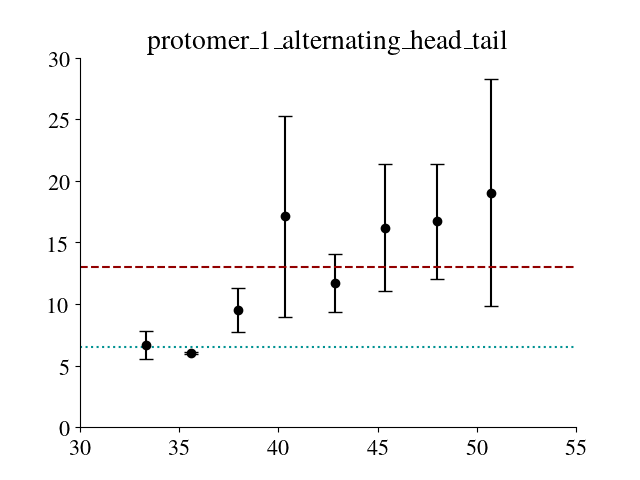

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [14]:
# Only get the ones that we want, and this way they're in a predictable order
#pdb_fns = ['protomer_1_alternating_head_tail.pdb',
#           'protomer_1_all_tail_tail.pdb',
#           'protomer_1_all_head_tail.pdb',
#           'protomer_1_all_head_head.pdb']
pdb_fns = ['protomer_1_alternating_head_tail.pdb']

p = pretty_error_plot(#xlabel="Concentration (mM)", ylabel="Distance (nm)", #title="Average distance from centroid",
                      fs=(10, 15), use_legend=False, rescale_plot=False)
for fn in pdb_fns:
    data_plot  = df_data.loc[(df_data['mutation'] == 'None') &
                             (df_data['pdb_file'] == fn)]
    data_plot.sort_values(by='kappa')
    p.add_plot(x=kappa_to_conc(data_plot['kappa']), y=np.array(data_plot['avg_rg_mean']), yerr=data_plot['avg_rg_std'],
               linestyle='None', marker='o', color='k',
               plot_title=fn.replace('.pdb', '').replace('protomer_1_alternating_head_tail_', '').replace('_', '\\_'))
p.disp(True)
for i, ax in enumerate([p.ax]):
    ax.set_ylim([0, 30])
    ax.set_xlim([30, 55])
    if i == 0:
        ax.axhline(y = 6.5, xmin=0, xmax=1, linestyle=':', label='intact', c=(0/255, 146/255, 146/255))
        ax.axhline(y = 13, xmin=0, xmax=1, linestyle='--', label='denatured', c=(146/255, 0/255, 0/255))
    else:
        ax.axhline(y = 6.5, xmin=0, xmax=1, linestyle=':', c=(0/255, 109/255, 219/255))
        ax.axhline(y = 13, xmin=0, xmax=1, linestyle='--', c=(146/255, 0/255, 0/255))
#p.fig.legend()
p.fig.savefig("images/Average_faceted_new.eps", format='eps')